In [1]:
directory = "/data/s1968653/Vanilla_output/"

In [2]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
import amuse.plot as plot
from tqdm import tqdm
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.lab import Mercury
from amuse.community.ph4.interface import ph4
from amuse.lab import Huayno
from amuse.io import write_set_to_file, read_set_from_file

In [3]:
def random_positions_and_velocities(N_objects, sun_loc):
    positions = np.zeros((N_objects, 3)) | units.AU
    velocities = np.zeros((N_objects,3)) | units.kms
    
    m_sun = 1 | units.MSun
    m_oort = 0 | units.MSun
    for i in range(N_objects):
        a = np.random.uniform(4, 40) | units.AU
        e = np.random.uniform(0, 0.05)
        inclination = np.random.uniform(-5, 5) | units.deg
        true_anomaly = np.random.uniform (0, 360) | units.deg
        arg_of_periapsis = np.random.uniform(0, 360) | units.deg
        long_of_ascending_node = np.random.uniform(0, 360) | units.deg
        sun_and_oort = new_binary_from_orbital_elements(m_sun, m_oort, 
                                          a, e, true_anomaly, inclination, long_of_ascending_node, arg_of_periapsis, G=constants.G)
        positions[i] = (sun_and_oort[1].x+sun_loc[0]), (sun_and_oort[1].y+sun_loc[1]), (sun_and_oort[1].z+sun_loc[2])
        velocities[i]= sun_and_oort[1].vx, sun_and_oort[1].vy, sun_and_oort[1].vz
    return positions, velocities

In [4]:
def merge_two_bodies(bodies, particles_in_encounter):
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two objects (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    
    if particles_in_encounter[0].mass == 0 | units.MSun:
        bodies.remove_particle(particles_in_encounter[0])
    elif particles_in_encounter[1].mass == 0 | units.MSun:
        bodies.remove_particle(particles_in_encounter[1])
    elif particles_in_encounter[0].mass == 0 | units.MSun and particles_in_encounter[1].mass == 0 | units.MSun:
        bodies.remove_particles(particles_in_encounter)

In [5]:
def resolve_collision(collision_detection, gravity_code, bodies, time):
    print("We have a actual collision.")
    print("This happened at time=", time.in_(units.yr))
    for ci in range(len(collision_detection.particles(0))): 
        encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
        colliding_objects = encountering_particles.get_intersecting_subset_in(bodies)
        merge_two_bodies(bodies, colliding_objects)
        bodies.synchronize_to(gravity_code.particles)

In [6]:
#Here we generate a basic solarsystem, with only the gas giants
from amuse.ext.solarsystem import new_solar_system

def create_system():
    
    system = new_solar_system()
    system = system[system.mass > 10**-5 | units.MSun]
    system.move_to_center()
    return system
    
    
basic_giants_system = create_system()

|S11


In [7]:
#Define the number of Oort objects and create random velocities and positions
N_objects = 10**2
sun_loc = [basic_giants_system[0].x.in_(units.AU), basic_giants_system[0].y.in_(units.AU), basic_giants_system[0].z.in_(units.AU)]
positions, velocities = random_positions_and_velocities(N_objects, sun_loc)

In [8]:
#Here we add the Oort cloud objects, according to a chosen distribution
def add_comet_objects(system, N_objects, rand_pos, rand_vel):
    
    for i in tqdm(range(N_objects)):
        oort = Particles(1)
        oort.name = "OORT_" + str(i)
        oort.mass = 0.0 | units.MSun
        oort.radius = (2.3 | units.km).in_(units.RSun) #This is purely non-zero for collisional purposes
        oort.position = (rand_pos[i, 0], rand_pos[i, 1], rand_pos[i, 2])
        oort.velocity = (rand_vel[i, 0], rand_vel[i, 1], rand_vel[i, 2])

        system.add_particle(oort)
    return system

complete_system = add_comet_objects(basic_giants_system, N_objects, positions, velocities)

100%|██████████| 100/100 [00:00<00:00, 542.27it/s]


In [9]:
final_system = complete_system
final_system.move_to_center()

In [10]:
#Here we perform the conversion for the system
converter_length = get_orbital_elements_from_binary(final_system[0:2], G = constants.G)[2].in_(units.AU)
final_converter=nbody_system.nbody_to_si(final_system.mass.sum(), 
                                   converter_length)

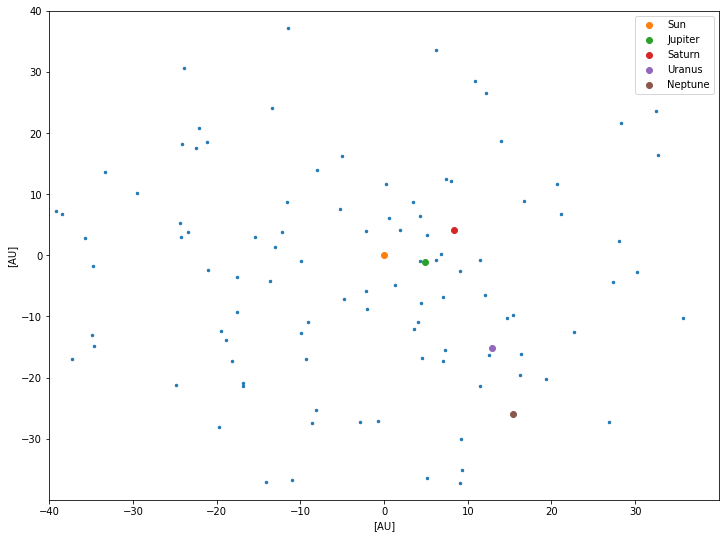

  0%|          | 1/1000 [00:00<12:18,  1.35it/s]

The solar position is:  [-0.00835192200898, 0.00192107034645, 0.000214528438915] AU
The amount of currently escaped comets is  0
The amount of dead comets is  0
The centre of mass velocity is  [-2.70688942148e-19, 1.51585807603e-18, -1.86098647727e-20] kms


In [ ]:
#Here we evolve the basic system, without grandtack or Milky way potential

def vanilla_evolver(particle_system, converter, N_objects, end_time=4*10**3, time_step=0.1):
    
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    if N_objects > 2*10**3:
        gravity_code = Mercury(final_converter)
    else:
        gravity_code = Huayno(final_converter)
    
    stopping_condition = gravity_code.stopping_conditions.collision_detection
    stopping_condition.enable()
    
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    times = np.arange(0., end_time, time_step) | units.yr
    
    dead_comets = []
    
    for i in tqdm(range(len(times))):
        gravity_code.evolve_model(times[i])
        while stopping_condition.is_set():
            resolve_collision(stopping_condition, gravity_code, particle_system, times[i])
            ch_g2l.copy()
            gravity_code.evolve_model(times[i])
        ch_g2l.copy()
            
        if times[i] in times:
            plot.scatter(gravity_code.particles.x.in_(units.AU), gravity_code.particles.y.in_(units.AU), s= 6)
            # Plotting an AU around Jupiter to see if objects are captured
            plot.xlim(gravity_code.particles[0].x -  (40 | units.AU), gravity_code.particles[0].x + (40 | units.AU))
            plot.ylim(gravity_code.particles[0].y -  (40 | units.AU), gravity_code.particles[0].y + (40 | units.AU))
            for i in range(5):
                plot.scatter(gravity_code.particles[i].x.in_(units.AU), gravity_code.particles[i].y.in_(units.AU), label = names[i])
            #plot.text(-35, 32, "Time = " + str(t.value_in(units.yr))[0:7] + " yrs.")
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(12, 9)
            clear_output(wait=True) 
            plt.show()
            
        if i%(100) == 0:
            write_set_to_file(particle_system, directory + 'Vanilla_run1_time=' +str(np.log10(times[i].value_in(units.yr)))[0:5] +'.hdf5', format='hdf5', overwrite_file = True)
        
        #Removing escaped comets
        out_of_bounds, escaped_comets = [], []
        for i in range(len(particle_system)):
            if particle_system[i].position.length() > 500 | units.AU:
                escaped_comets.append(particle_system[i].name)
                if particle_system[i].position.length() > 250000 | units.AU:
                    out_of_bounds.append(particle_system[i])
                    dead_comets.append(particle_system[i])
        for particle in out_of_bounds:
            particle_system.remove_particle(particle)
            particle_system.synchronize_to(gravity_code.particles)
        
        print("The solar position is: ", particle_system[0].position.in_(units.AU))
        print("The amount of currently escaped comets is ", len(escaped_comets))
        print("The amount of dead comets is ", len(dead_comets))
        print("The centre of mass velocity is ", particle_system.center_of_mass_velocity().in_(units.kms))
                
    gravity_code.stop()
    write_set_to_file(particle_system, directory + 'Vanilla_run1_final.hdf5', format='hdf5', overwrite_file = True)
    np.savetxt(directory + 'Vanilla_run1_escaped.txt', escaped_comets)
    return particle_system
    
    
vanilla_evolved_system = vanilla_evolver(final_system, final_converter, N_objects, end_time= 10**8, time_step= 10**5)
